In [153]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [154]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 2/'
path_to_data_train = "dstc8-train.txt"
path_to_data_val = "dstc8-val-candidates.txt"
path_to_data_test = "dstc8-test-candidates.txt"

In [155]:
# Code extended from the following source: https://www.tensorflow.org/tutorials/text/nmt_with_attention
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.test.is_gpu_available()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import concurrent.futures
import collections
import unicodedata
import re
import numpy as np
import os
import io
import sys
import math
import time

In [156]:
#########################################
# RNN ENCODER-DECODER 
#########################################
#https://stackoverflow.com/questions/55490830/how-to-set-an-initial-state-for-a-bidirectional-lstm-layer-in-keras
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # tell LSTM you want to get the states, and sequences returned
        self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=0.1,
                                                                        go_backwards= True))


    def call(self, x, hidden):
        x = self.embedding(x)
        # no need to pass [hidden, hidden], just pass it as is
        output, forward_h, forward_c, backward_h, backward_c = self.lstmb(x, initial_state=hidden)
        return output, forward_h, forward_c, backward_h, backward_c


    def initialize_hidden_state(self):
      #4 for forward_h, forward_c, backward_h, backward_c
        return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dec_units,    
                                                                    return_sequences=True,
                                                                    return_state=True,
                                                                    dropout=0.1,
                                                                    go_backwards= True))

    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, initial_state):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    #Attention
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    #Take outputs from lstm
    x, h, c, b, b_c = self.lstmb(x, initial_state = initial_state)
    #Set states to both forward and backward pass
    states = tf.concat([h, b], axis=1)
    #Reshape output
    output = tf.reshape(x, (-1, x.shape[2]))
    #Set output
    x = self.fc(output)
    return x, states, attention_weights
    

In [157]:
#########################################
# TEXT PROCESSING
#########################################

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,Ã‚Â¿])", r" \1 ", w)
  w = re.sub(r'[" "]', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,Ã‚Â¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #print(lines)

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines]
  #print(word_pairs)
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path):
  inp_lang, targ_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(root_path + path_to_data_train)
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]
#print(len(input_tensor_train), len(target_tensor_train))

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

#print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
#print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

1 ----> <start>
4 ----> domain=music
16 ----> <sod>
29 ----> can
11 ----> you
36 ----> find
33 ----> song
65 ----> s
72 ----> from
53 ----> $artist
65 ----> s
463 ----> ablum
64 ----> $album
8 ----> ?
2 ----> <end>

1 ----> <start>
12 ----> i
65 ----> found
34 ----> $count
13 ----> song
25 ----> from
16 ----> $artist
67 ----> s
17 ----> $album
22 ----> album
3 ----> .
4 ----> the
13 ----> song
10 ----> is
8 ----> $song
6 ----> name
3 ----> .
2 ----> <end>


In [158]:
#########################################
# TRAINING
#########################################

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    #Get outputs from encoder
    enc_output, enc_hidden, forward_c, backward_h, backward_c = encoder(inp, enc_hidden) 
    #Inital state from outputs
    encoder_state = [enc_hidden, forward_c, backward_h, backward_c]
    #Hidden layer for decoder
    dec_hidden = tf.concat([forward_h, backward_h], axis=1)

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]): 
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, initial_state= encoder_state)
      loss += loss_function(targ[:, t], predictions)
      

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

def train_model(EPOCHS):
    loss_plot = []
    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden) #Breaks here
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        if (epoch + 1) == 100:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                            total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        #Plot loss
        loss_plot.append(total_loss/steps_per_epoch)
        plt.plot(loss_plot, 'r')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

In [159]:
#########################################
# EVALUATION
#########################################

def evaluate(sentence, candidate=None, id=None):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = []
    for word in sentence.split(' '):
        if word in inp_lang.word_index:
            inputs.append(inp_lang.word_index[word])

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    value = 0
    #Set hidden to correct shape
    hidden = [tf.zeros((1, units)) for i in range(4)]
    #Get outputs from encoder
    enc_out, forward_h, forward_c, backward_h, backward_c = encoder(inputs, hidden)
    #Create inital state
    encoder_state = [forward_h, forward_c, backward_h, backward_c]
    #Create hidden for decoder
    dec_hidden = tf.concat([forward_h, backward_h], axis=1)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    candidate_words = []
    if candidate != None:
        candidate = candidate + " <end>"
        for word in candidate.split(' '):
            if word in targ_lang.word_index:
                candidate_words.append(targ_lang.word_index[word])

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, initial_state = encoder_state)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        if candidate == None:
            predicted_id = tf.argmax(predictions[0]).numpy()
        else:
            predicted_id = candidate_words[t]

        value += predictions[0][predicted_id].numpy()

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, value/t, id, sentence, attention_plot

        result += targ_lang.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, value/t, id, sentence, attention_plot

def loadTestData(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    lines = text.strip().split('\n')

    allCandidates = []
    candidates = []
    contexts = []

    for i in range(0, len(lines)):
        if lines[i].startswith("CONTEXT:"): 
            candidate = lines[i][8:]
            contexts.append(candidate)
            continue
            
        elif len(lines[i].strip()) == 0:
            if i>0: allCandidates.append(candidates)
            candidates = []
            
        else:
            candidate = lines[i][12:]
            candidates.append(candidate)
    
    allCandidates.append(candidates)
    return allCandidates, contexts

def getRankValue(target_value, unsorted_distribution):
    sorted_distribution = sorted(unsorted_distribution, reverse=True)
    #print("sorted_distribution="+str(sorted_distribution))
    for i in range (0, len(sorted_distribution)):
        value = sorted_distribution[i]
        #print("value(rank"+str((i+1))+")="+str(value)+" <==> target="+str(target_value))
        if value == target_value: 
            return 1/(i+1)
    return None
    
def evaluate_model(filename_testdata, checkpoint_dir, eval):
  #save to different files for eval and test comparison
    if eval == True:
      f_predicted = open(checkpoint_dir+"/dstc8-sgd-predicted.txt", 'w')
      f_reference = open(checkpoint_dir+"/dstc8-sgd-reference.txt", 'w')
    else:
      f_predicted = open(checkpoint_dir+"/dstc8-sgd-predicted_test.txt", 'w')
      f_reference = open(checkpoint_dir+"/dstc8-sgd-reference_test.txt", 'w')
    
    candidates, contexts = loadTestData(filename_testdata)
    correct_predictions = 0
    total_predictions = 0
    cumulative_mrr = 0
    recall_at_1 = None
    mrr = None

    for i in range(0, len(contexts)):
        total_predictions += 1
        #best_value = 0
        #best_index = 0
        response = ""
        response_value = 0
        response_attention_plot = []
        target_value = 0
        context = contexts[i]
        reference = candidates[i][0]
        distribution = []
        jobs = []

        with concurrent.futures.ThreadPoolExecutor() as executor:
            jobs.append(executor.submit(evaluate, preprocess_sentence(context), None, 0))
            for j in range (0,len(candidates[i])):
                jobs.append(executor.submit(evaluate, preprocess_sentence(context), candidates[i][j], (j+1)))
        
        for future in concurrent.futures.as_completed(jobs):
            candidate_sentence, value_candidate, id, inp_sentence, attention_plot = future.result()
            if id == 0:
                response = candidate_sentence
                response_value = value_candidate
                response_attention_plot = attention_plot
                #print(str(i+1)+' '+str(id)+' predicted_sentence:', candidate_sentence, 'value:', value_candidate) 
            else:
                distribution.append(value_candidate)
                #print(str(i+1)+' '+str(id)+' candidate_sentence:', candidate_sentence, 'value:', value_candidate) 

            if id == 1: target_value = value_candidate

            #if value_candidate > best_value:
            #    best_value = value_candidate
            #    best_index = id

        rank = getRankValue(target_value, distribution)
        cumulative_mrr += rank
        correct_predictions += 1 if rank == 1 else 0
        
        recall_at_1 = correct_predictions/total_predictions
        mrr = cumulative_mrr/total_predictions
        #print(str(i)+' INPUT='+str(context)+' PREDICTED='+str(response)+' REFERENCE='+str(reference)+' CumulativeR@1='+str(recall_at_1)+' ('+str(correct_predictions)+' out of '+str(total_predictions)+') CumulativeMRR='+str(mrr)+' ('+str(cumulative_mrr)+' out of '+str(total_predictions)+')')
        #print("")
        #plot_attention(response_attention_plot, context.split(' '), response.split(' '))

        f_predicted.write(response+"\n")
        f_reference.write(reference+"\n")
    
    f_predicted.close()
    f_reference.close()

    print("BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under "+str(checkpoint_dir))
    print("RECALL@1="+str(recall_at_1))
    print("Mean Reciprocal Rank="+str(mrr))
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

Training
Epoch 1 Batch 0 Loss 2.0958
Epoch 1 Loss 1.4188
Time taken for 1 epoch 111.47756791114807 sec



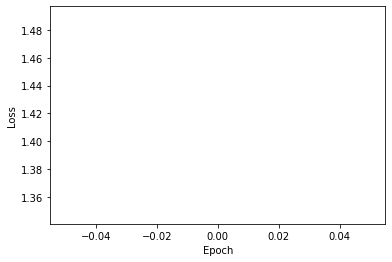

Epoch 2 Batch 0 Loss 1.1066
Epoch 2 Loss 0.8276
Time taken for 1 epoch 21.658574104309082 sec



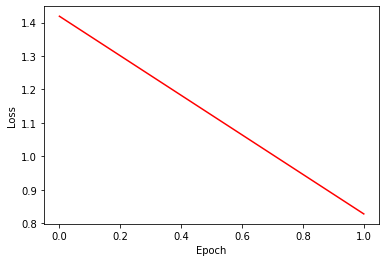

Epoch 3 Batch 0 Loss 0.8173
Epoch 3 Loss 0.6799
Time taken for 1 epoch 21.631552696228027 sec



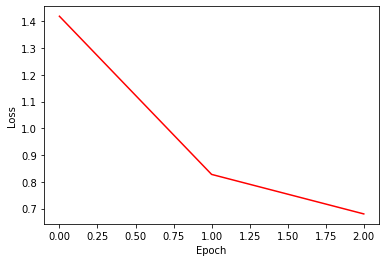

Epoch 4 Batch 0 Loss 0.5887
Epoch 4 Loss 0.5704
Time taken for 1 epoch 21.640605688095093 sec



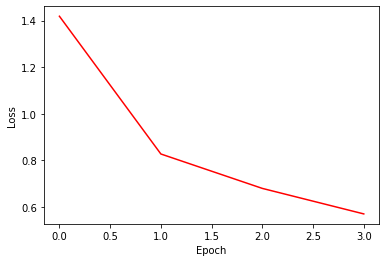

Epoch 5 Batch 0 Loss 0.4988
Epoch 5 Loss 0.5082
Time taken for 1 epoch 21.633089065551758 sec



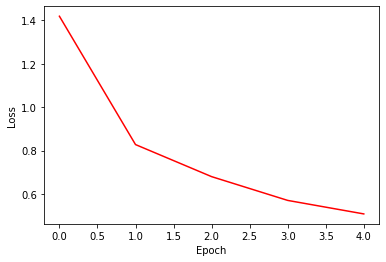

Epoch 6 Batch 0 Loss 0.4882
Epoch 6 Loss 0.4737
Time taken for 1 epoch 21.487242937088013 sec



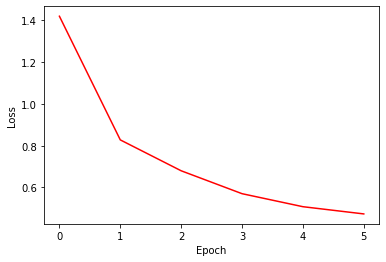

Epoch 7 Batch 0 Loss 0.4317
Epoch 7 Loss 0.4480
Time taken for 1 epoch 21.657113552093506 sec



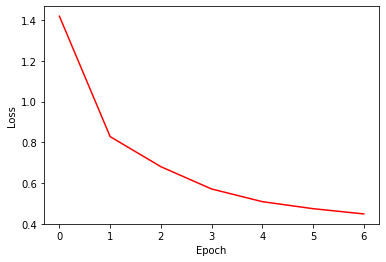

Epoch 8 Batch 0 Loss 0.5001
Epoch 8 Loss 0.4269
Time taken for 1 epoch 21.63743233680725 sec



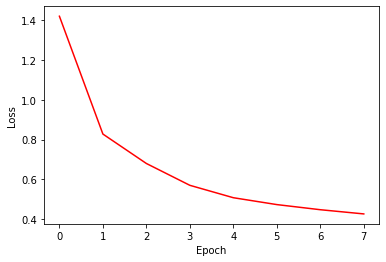

Epoch 9 Batch 0 Loss 0.4553
Epoch 9 Loss 0.4064
Time taken for 1 epoch 21.634605884552002 sec



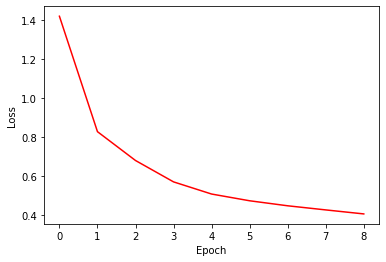

Epoch 10 Batch 0 Loss 0.4973
Epoch 10 Loss 0.3890
Time taken for 1 epoch 21.64723253250122 sec



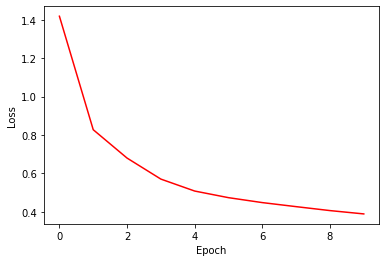

Epoch 11 Batch 0 Loss 0.4157
Epoch 11 Loss 0.3725
Time taken for 1 epoch 21.680771589279175 sec



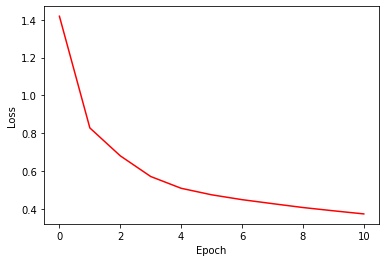

Epoch 12 Batch 0 Loss 0.3597
Epoch 12 Loss 0.3565
Time taken for 1 epoch 21.473873615264893 sec



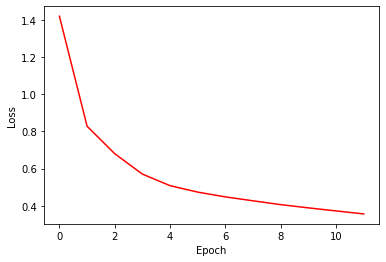

Epoch 13 Batch 0 Loss 0.2831
Epoch 13 Loss 0.3410
Time taken for 1 epoch 21.64242196083069 sec



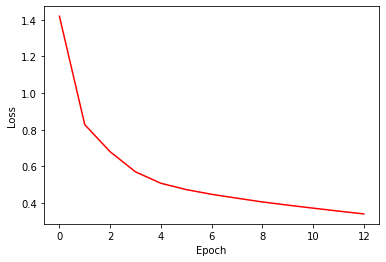

Epoch 14 Batch 0 Loss 0.3091
Epoch 14 Loss 0.3261
Time taken for 1 epoch 21.64060640335083 sec



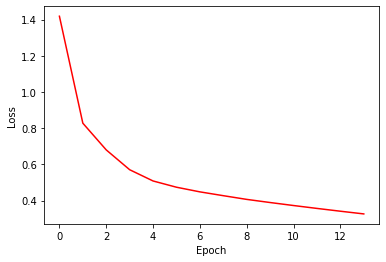

Epoch 15 Batch 0 Loss 0.2755
Epoch 15 Loss 0.3161
Time taken for 1 epoch 21.643289804458618 sec



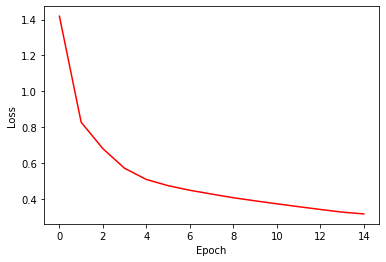

Epoch 16 Batch 0 Loss 0.2701
Epoch 16 Loss 0.3063
Time taken for 1 epoch 21.65690326690674 sec



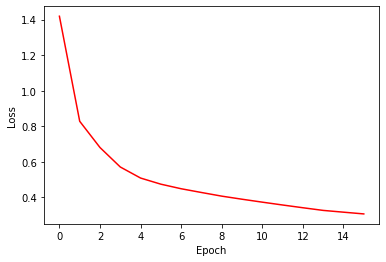

Epoch 17 Batch 0 Loss 0.2380
Epoch 17 Loss 0.2818
Time taken for 1 epoch 21.638428926467896 sec



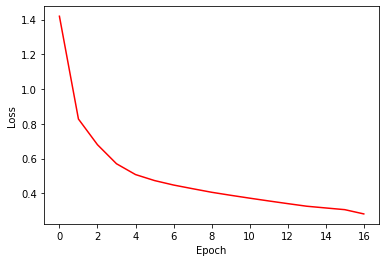

Epoch 18 Batch 0 Loss 0.2732
Epoch 18 Loss 0.2662
Time taken for 1 epoch 21.465860843658447 sec



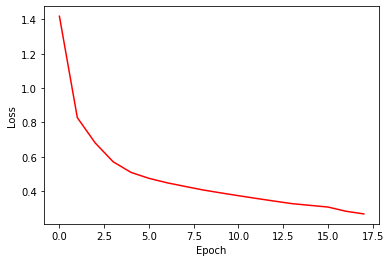

Epoch 19 Batch 0 Loss 0.2562
Epoch 19 Loss 0.2500
Time taken for 1 epoch 21.639522790908813 sec



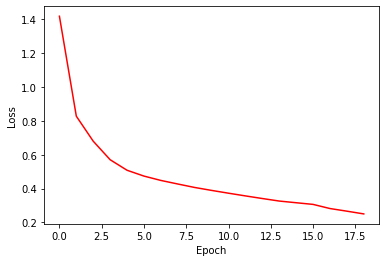

Epoch 20 Batch 0 Loss 0.1844
Epoch 20 Loss 0.2242
Time taken for 1 epoch 21.67420506477356 sec



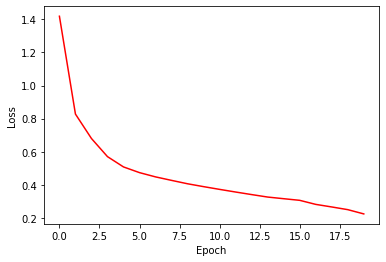

Epoch 21 Batch 0 Loss 0.1827
Epoch 21 Loss 0.2026
Time taken for 1 epoch 21.678476572036743 sec



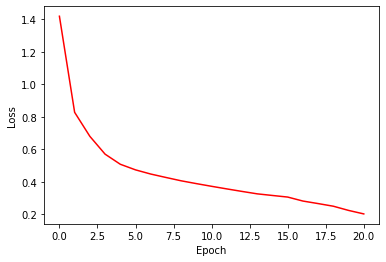

Epoch 22 Batch 0 Loss 0.1775
Epoch 22 Loss 0.1849
Time taken for 1 epoch 21.662452459335327 sec



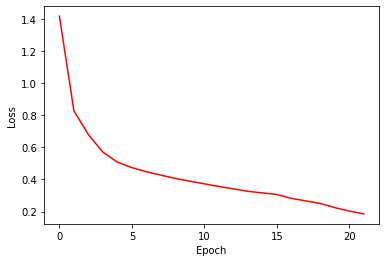

Epoch 23 Batch 0 Loss 0.1516
Epoch 23 Loss 0.1644
Time taken for 1 epoch 21.677443504333496 sec



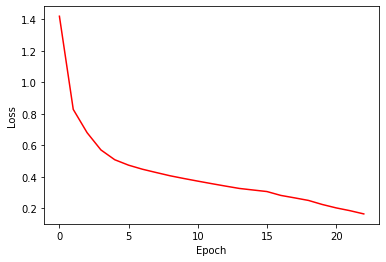

Epoch 24 Batch 0 Loss 0.1332
Epoch 24 Loss 0.1456
Time taken for 1 epoch 21.495574712753296 sec



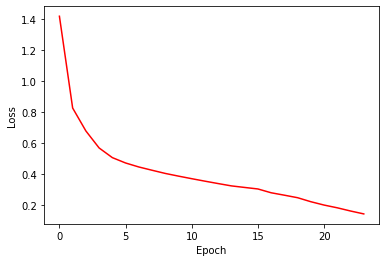

Epoch 25 Batch 0 Loss 0.1284
Epoch 25 Loss 0.1269
Time taken for 1 epoch 21.6904354095459 sec



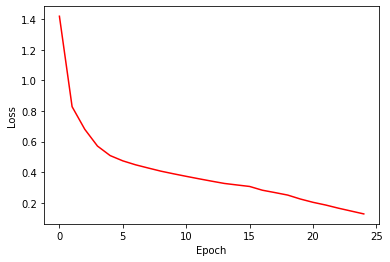

Epoch 26 Batch 0 Loss 0.0922
Epoch 26 Loss 0.1098
Time taken for 1 epoch 21.66179084777832 sec



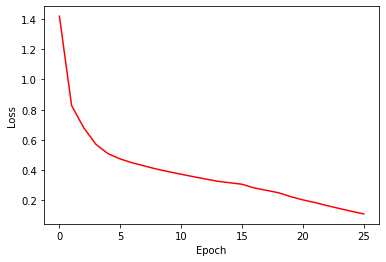

Epoch 27 Batch 0 Loss 0.1037
Epoch 27 Loss 0.0977
Time taken for 1 epoch 21.64294719696045 sec



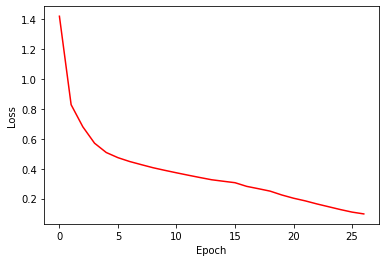

Epoch 28 Batch 0 Loss 0.0839
Epoch 28 Loss 0.0862
Time taken for 1 epoch 21.656898260116577 sec



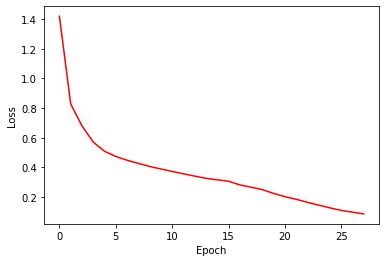

Epoch 29 Batch 0 Loss 0.0751
Epoch 29 Loss 0.0755
Time taken for 1 epoch 21.662374258041382 sec



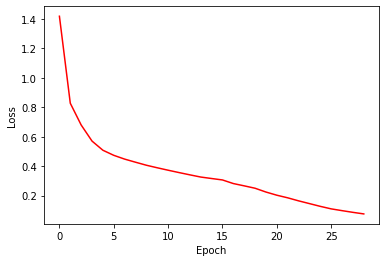

Epoch 30 Batch 0 Loss 0.0724
Epoch 30 Loss 0.0701
Time taken for 1 epoch 21.47463321685791 sec



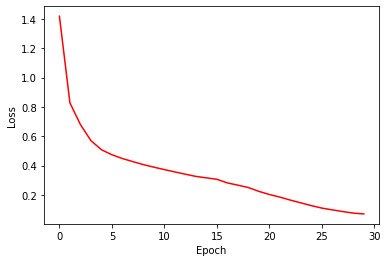

Epoch 31 Batch 0 Loss 0.0479
Epoch 31 Loss 0.0600
Time taken for 1 epoch 21.61074686050415 sec



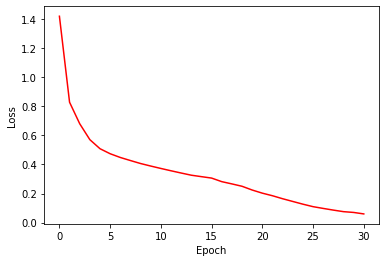

Epoch 32 Batch 0 Loss 0.0436
Epoch 32 Loss 0.0534
Time taken for 1 epoch 21.616516828536987 sec



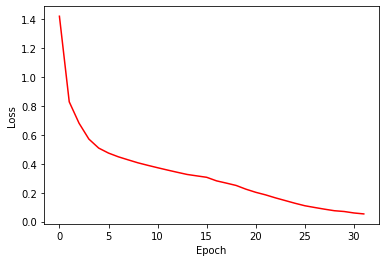

Epoch 33 Batch 0 Loss 0.0366
Epoch 33 Loss 0.0483
Time taken for 1 epoch 21.628595113754272 sec



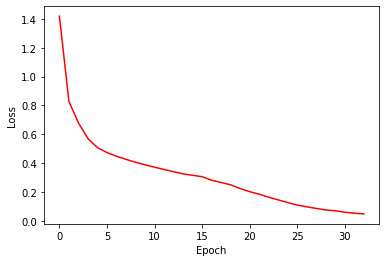

Epoch 34 Batch 0 Loss 0.0440
Epoch 34 Loss 0.0441
Time taken for 1 epoch 21.641047477722168 sec



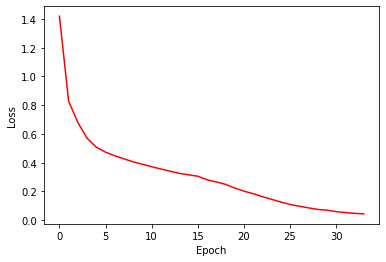

Epoch 35 Batch 0 Loss 0.0356
Epoch 35 Loss 0.0422
Time taken for 1 epoch 21.61061429977417 sec



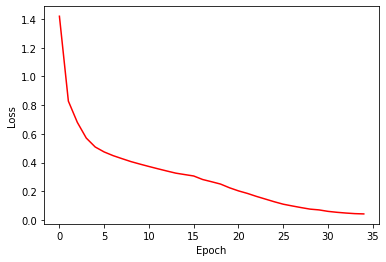

Epoch 36 Batch 0 Loss 0.0356
Epoch 36 Loss 0.0395
Time taken for 1 epoch 21.478639841079712 sec



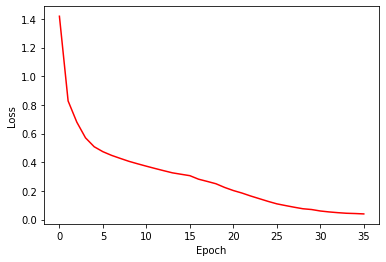

Epoch 37 Batch 0 Loss 0.0305
Epoch 37 Loss 0.0382
Time taken for 1 epoch 21.615466117858887 sec



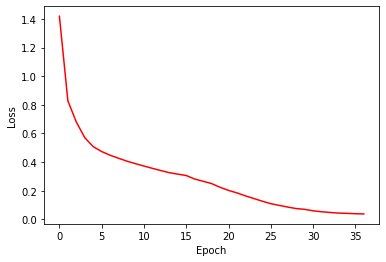

Epoch 38 Batch 0 Loss 0.0416
Epoch 38 Loss 0.0377
Time taken for 1 epoch 21.5901460647583 sec



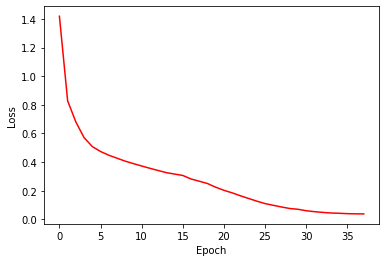

Epoch 39 Batch 0 Loss 0.0292
Epoch 39 Loss 0.0385
Time taken for 1 epoch 21.607780933380127 sec



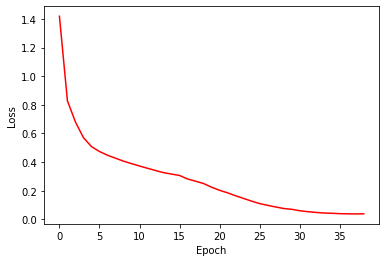

Epoch 40 Batch 0 Loss 0.0370
Epoch 40 Loss 0.0348
Time taken for 1 epoch 21.63392734527588 sec



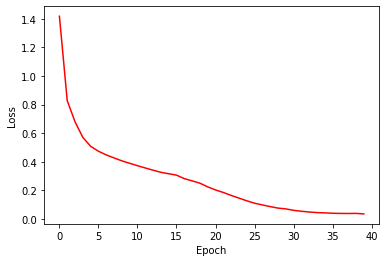

Epoch 41 Batch 0 Loss 0.0301
Epoch 41 Loss 0.0348
Time taken for 1 epoch 21.62940001487732 sec



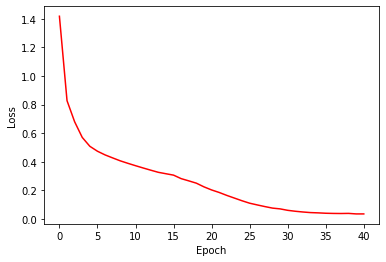

Epoch 42 Batch 0 Loss 0.0326
Epoch 42 Loss 0.0340
Time taken for 1 epoch 21.46768355369568 sec



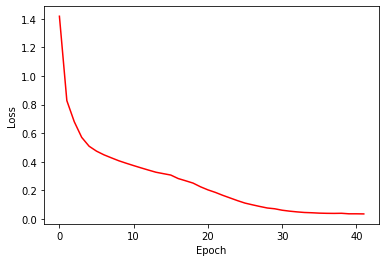

Epoch 43 Batch 0 Loss 0.0281
Epoch 43 Loss 0.0323
Time taken for 1 epoch 21.66905117034912 sec



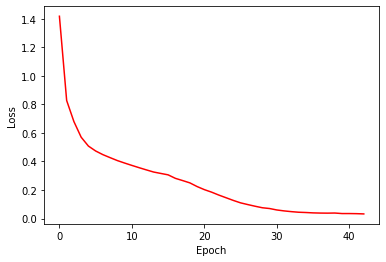

Epoch 44 Batch 0 Loss 0.0279
Epoch 44 Loss 0.0319
Time taken for 1 epoch 21.639596700668335 sec



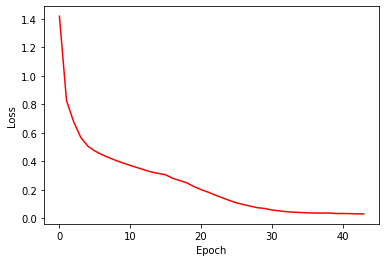

Epoch 45 Batch 0 Loss 0.0235
Epoch 45 Loss 0.0305
Time taken for 1 epoch 21.67031216621399 sec



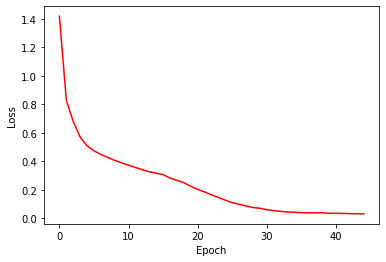

Epoch 46 Batch 0 Loss 0.0268
Epoch 46 Loss 0.0316
Time taken for 1 epoch 21.64801001548767 sec



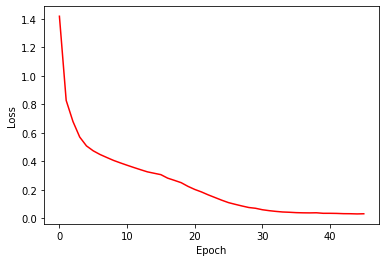

Epoch 47 Batch 0 Loss 0.0231
Epoch 47 Loss 0.0299
Time taken for 1 epoch 21.64247727394104 sec



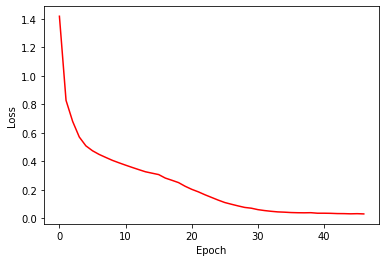

Epoch 48 Batch 0 Loss 0.0312
Epoch 48 Loss 0.0301
Time taken for 1 epoch 21.459733486175537 sec



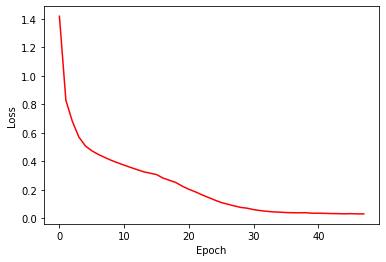

Epoch 49 Batch 0 Loss 0.0302
Epoch 49 Loss 0.0299
Time taken for 1 epoch 21.648120403289795 sec



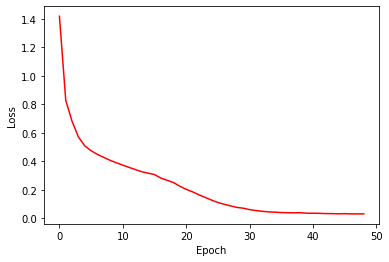

Epoch 50 Batch 0 Loss 0.0206
Epoch 50 Loss 0.0292
Time taken for 1 epoch 21.657190084457397 sec



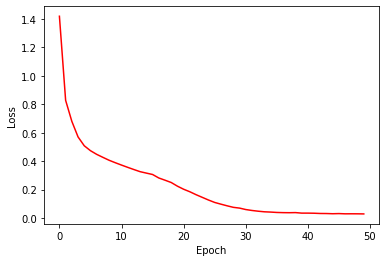

Epoch 51 Batch 0 Loss 0.0140
Epoch 51 Loss 0.0326
Time taken for 1 epoch 21.661004781723022 sec



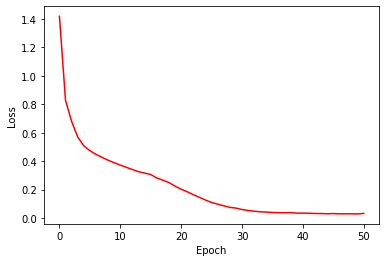

Epoch 52 Batch 0 Loss 0.0301
Epoch 52 Loss 0.0324
Time taken for 1 epoch 21.629381895065308 sec



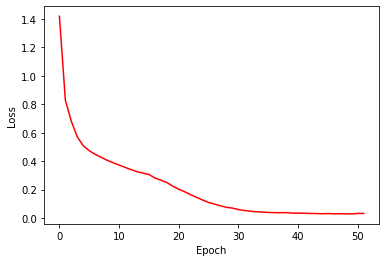

Epoch 53 Batch 0 Loss 0.0196
Epoch 53 Loss 0.0311
Time taken for 1 epoch 21.636714935302734 sec



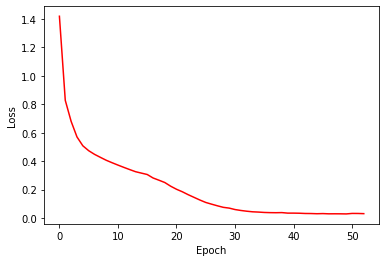

Epoch 54 Batch 0 Loss 0.0167
Epoch 54 Loss 0.0292
Time taken for 1 epoch 21.51330542564392 sec



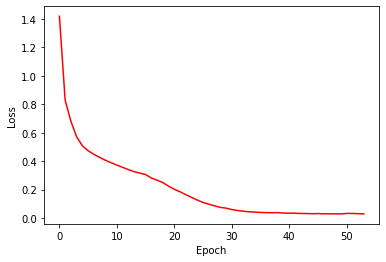

Epoch 55 Batch 0 Loss 0.0175
Epoch 55 Loss 0.0281
Time taken for 1 epoch 21.637080907821655 sec



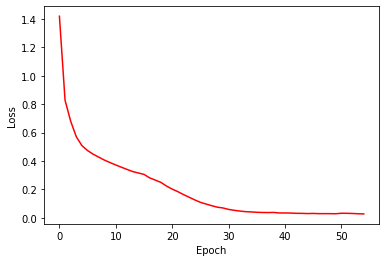

Epoch 56 Batch 0 Loss 0.0280
Epoch 56 Loss 0.0280
Time taken for 1 epoch 21.62360382080078 sec



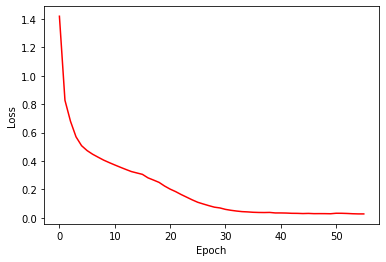

Epoch 57 Batch 0 Loss 0.0277
Epoch 57 Loss 0.0301
Time taken for 1 epoch 21.636939525604248 sec



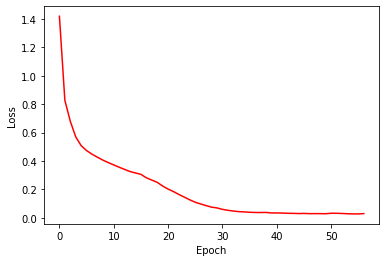

Epoch 58 Batch 0 Loss 0.0169
Epoch 58 Loss 0.0322
Time taken for 1 epoch 21.656938791275024 sec



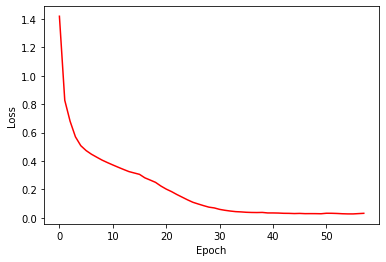

Epoch 59 Batch 0 Loss 0.0352
Epoch 59 Loss 0.0307
Time taken for 1 epoch 21.58985686302185 sec



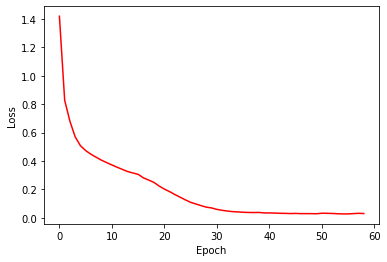

Epoch 60 Batch 0 Loss 0.0186
Epoch 60 Loss 0.0295
Time taken for 1 epoch 21.53110694885254 sec



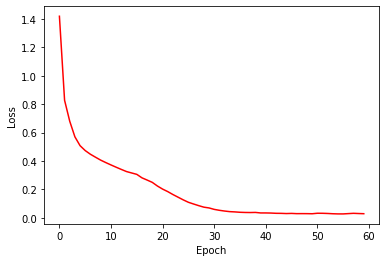

Epoch 61 Batch 0 Loss 0.0291
Epoch 61 Loss 0.0280
Time taken for 1 epoch 21.637221813201904 sec



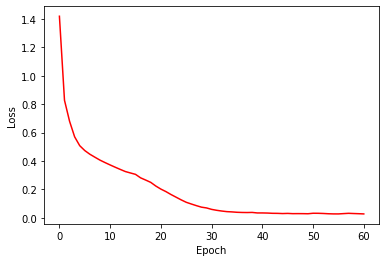

Epoch 62 Batch 0 Loss 0.0319
Epoch 62 Loss 0.0267
Time taken for 1 epoch 21.63261651992798 sec



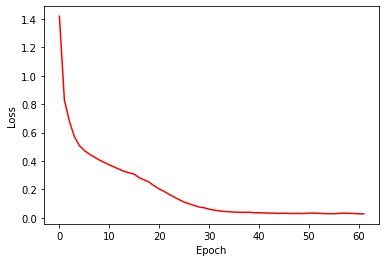

Epoch 63 Batch 0 Loss 0.0218
Epoch 63 Loss 0.0257
Time taken for 1 epoch 21.66301703453064 sec



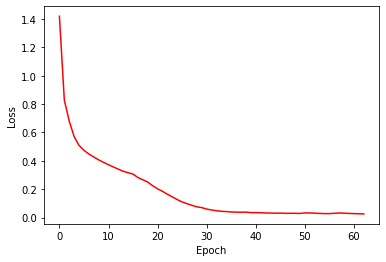

Epoch 64 Batch 0 Loss 0.0226
Epoch 64 Loss 0.0255
Time taken for 1 epoch 21.62720036506653 sec



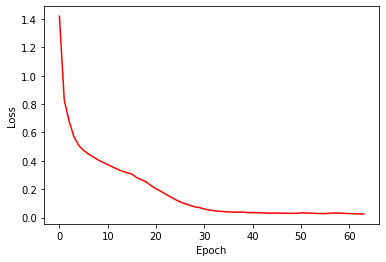

Epoch 65 Batch 0 Loss 0.0162
Epoch 65 Loss 0.0248
Time taken for 1 epoch 21.556669235229492 sec



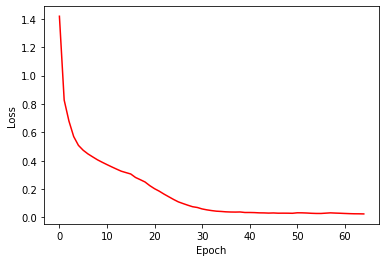

Epoch 66 Batch 0 Loss 0.0128
Epoch 66 Loss 0.0249
Time taken for 1 epoch 21.58922553062439 sec



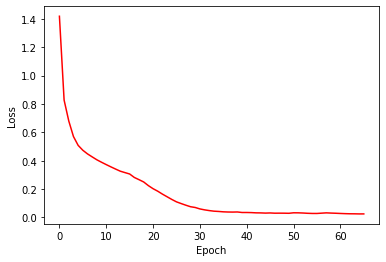

Epoch 67 Batch 0 Loss 0.0172
Epoch 67 Loss 0.0263
Time taken for 1 epoch 21.638208389282227 sec



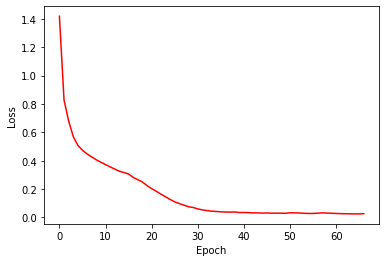

Epoch 68 Batch 0 Loss 0.0168
Epoch 68 Loss 0.0272
Time taken for 1 epoch 21.653566360473633 sec



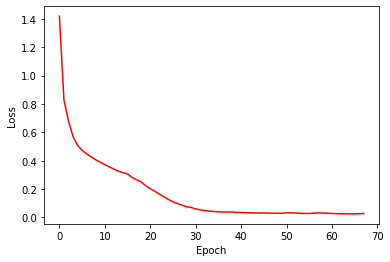

Epoch 69 Batch 0 Loss 0.0282
Epoch 69 Loss 0.0266
Time taken for 1 epoch 21.63905358314514 sec



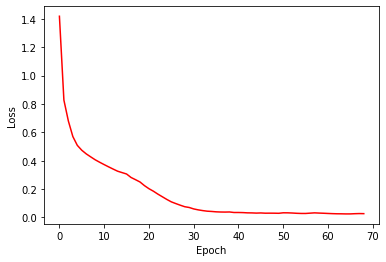

Epoch 70 Batch 0 Loss 0.0183
Epoch 70 Loss 0.0255
Time taken for 1 epoch 21.63407278060913 sec



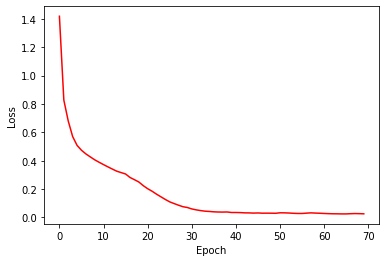

Epoch 71 Batch 0 Loss 0.0283
Epoch 71 Loss 0.0253
Time taken for 1 epoch 21.517003536224365 sec



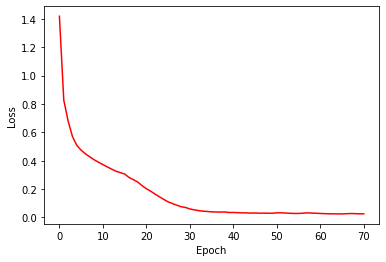

Epoch 72 Batch 0 Loss 0.0125
Epoch 72 Loss 0.0245
Time taken for 1 epoch 21.61294150352478 sec



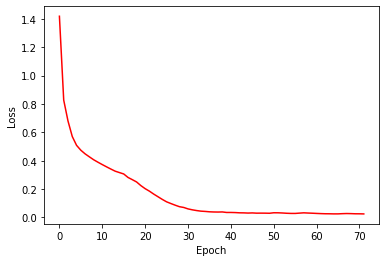

Epoch 73 Batch 0 Loss 0.0154
Epoch 73 Loss 0.0239
Time taken for 1 epoch 21.652530670166016 sec



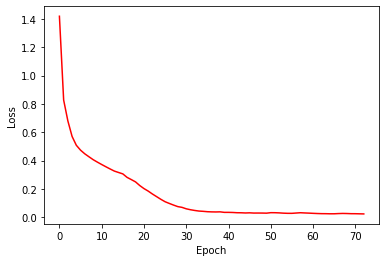

Epoch 74 Batch 0 Loss 0.0224
Epoch 74 Loss 0.0251
Time taken for 1 epoch 21.652037382125854 sec



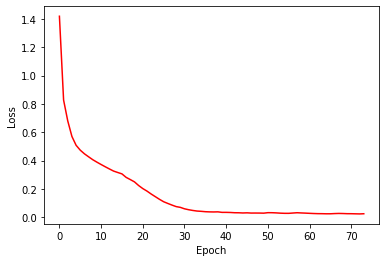

Epoch 75 Batch 0 Loss 0.0302
Epoch 75 Loss 0.0302
Time taken for 1 epoch 21.661107540130615 sec



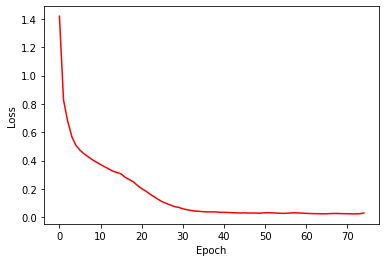

Epoch 76 Batch 0 Loss 0.0286
Epoch 76 Loss 0.0356
Time taken for 1 epoch 21.666621208190918 sec



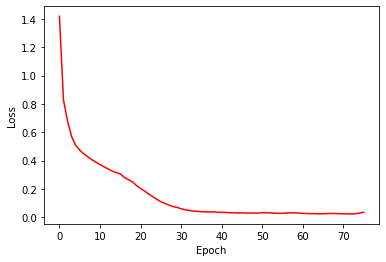

Epoch 77 Batch 0 Loss 0.0255
Epoch 77 Loss 0.0332
Time taken for 1 epoch 21.50162386894226 sec



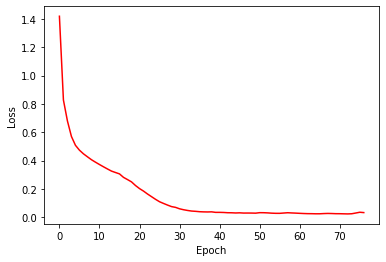

Epoch 78 Batch 0 Loss 0.0324
Epoch 78 Loss 0.0322
Time taken for 1 epoch 21.635859966278076 sec



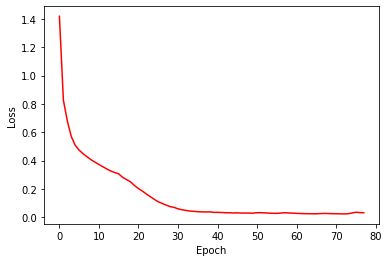

Epoch 79 Batch 0 Loss 0.0240
Epoch 79 Loss 0.0276
Time taken for 1 epoch 21.641961097717285 sec



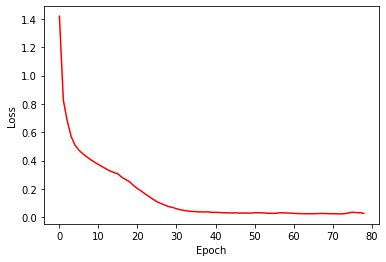

Epoch 80 Batch 0 Loss 0.0206
Epoch 80 Loss 0.0249
Time taken for 1 epoch 21.639565229415894 sec



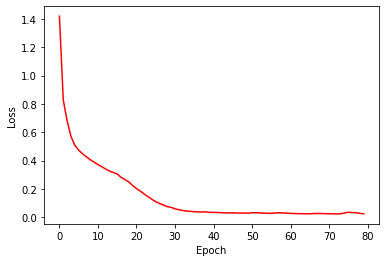

Epoch 81 Batch 0 Loss 0.0190
Epoch 81 Loss 0.0236
Time taken for 1 epoch 21.615140438079834 sec



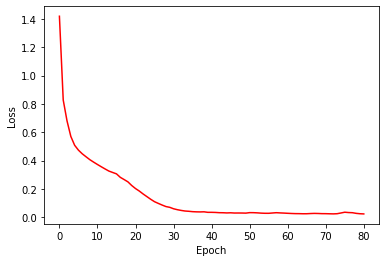

Epoch 82 Batch 0 Loss 0.0092
Epoch 82 Loss 0.0225
Time taken for 1 epoch 21.647270679473877 sec



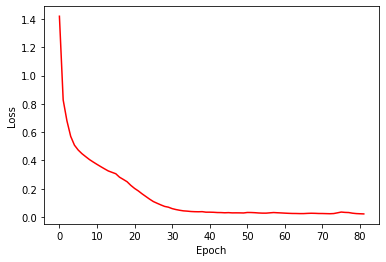

Epoch 83 Batch 0 Loss 0.0124
Epoch 83 Loss 0.0226
Time taken for 1 epoch 21.49368166923523 sec



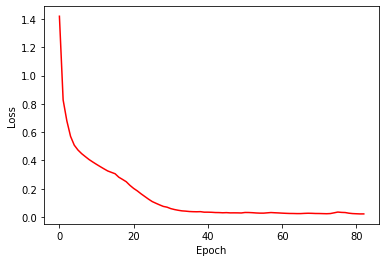

Epoch 84 Batch 0 Loss 0.0146
Epoch 84 Loss 0.0222
Time taken for 1 epoch 21.656368732452393 sec



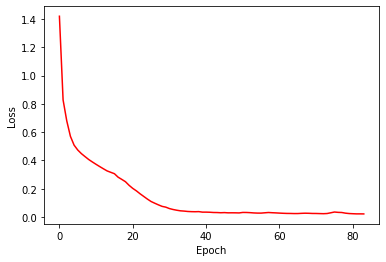

Epoch 85 Batch 0 Loss 0.0170
Epoch 85 Loss 0.0224
Time taken for 1 epoch 21.665016889572144 sec



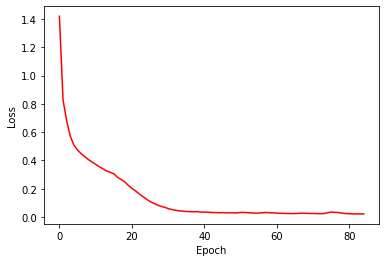

Epoch 86 Batch 0 Loss 0.0290
Epoch 86 Loss 0.0278
Time taken for 1 epoch 21.662540674209595 sec



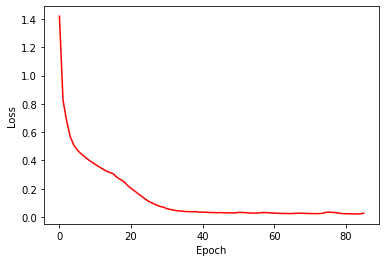

Epoch 87 Batch 0 Loss 0.0220
Epoch 87 Loss 0.0271
Time taken for 1 epoch 21.674195766448975 sec



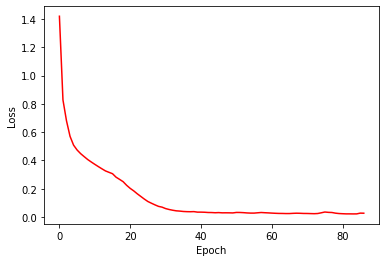

Epoch 88 Batch 0 Loss 0.0115
Epoch 88 Loss 0.0259
Time taken for 1 epoch 21.63618779182434 sec



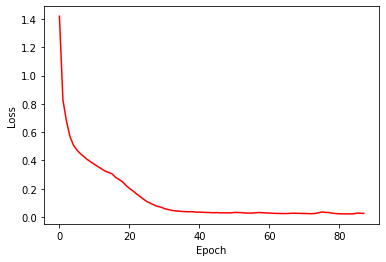

Epoch 89 Batch 0 Loss 0.0207
Epoch 89 Loss 0.0288
Time taken for 1 epoch 21.47597861289978 sec



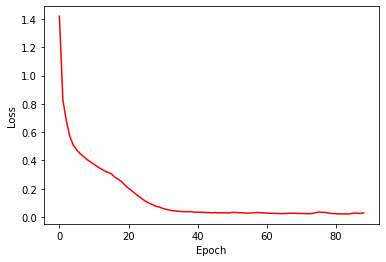

Epoch 90 Batch 0 Loss 0.0146
Epoch 90 Loss 0.0281
Time taken for 1 epoch 21.651792526245117 sec



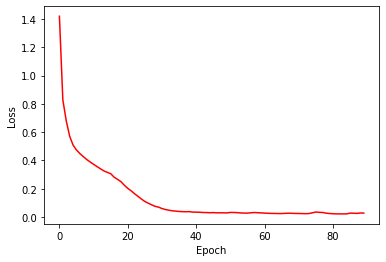

Epoch 91 Batch 0 Loss 0.0205
Epoch 91 Loss 0.0268
Time taken for 1 epoch 21.645334482192993 sec



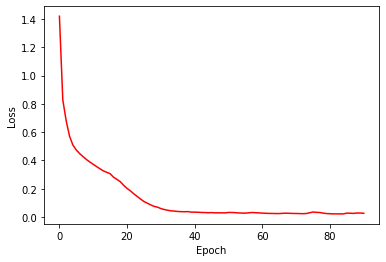

Epoch 92 Batch 0 Loss 0.0163
Epoch 92 Loss 0.0243
Time taken for 1 epoch 21.63932728767395 sec



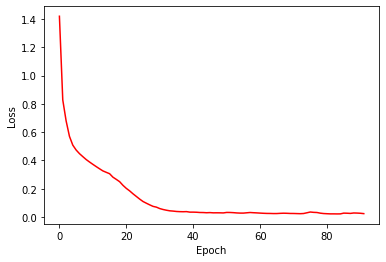

Epoch 93 Batch 0 Loss 0.0182
Epoch 93 Loss 0.0226
Time taken for 1 epoch 21.630521774291992 sec



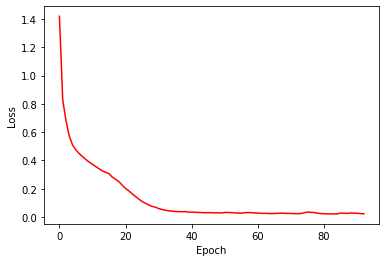

Epoch 94 Batch 0 Loss 0.0140
Epoch 94 Loss 0.0216
Time taken for 1 epoch 21.657531023025513 sec



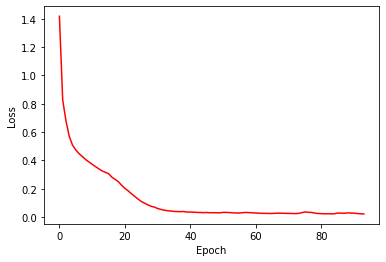

Epoch 95 Batch 0 Loss 0.0179
Epoch 95 Loss 0.0216
Time taken for 1 epoch 21.4334397315979 sec



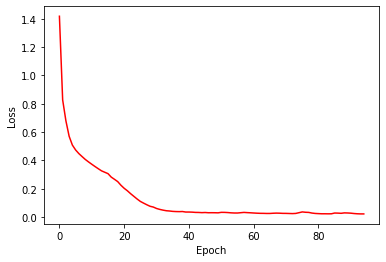

Epoch 96 Batch 0 Loss 0.0087
Epoch 96 Loss 0.0218
Time taken for 1 epoch 21.598080158233643 sec



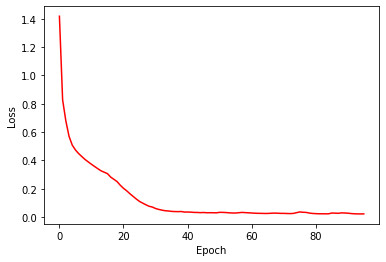

Epoch 97 Batch 0 Loss 0.0194
Epoch 97 Loss 0.0223
Time taken for 1 epoch 21.602346658706665 sec



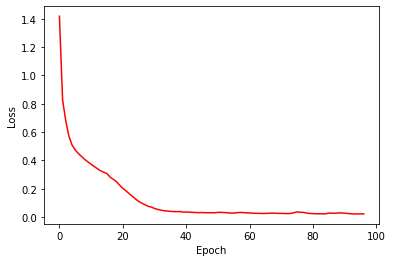

Epoch 98 Batch 0 Loss 0.0078
Epoch 98 Loss 0.0263
Time taken for 1 epoch 21.615769386291504 sec



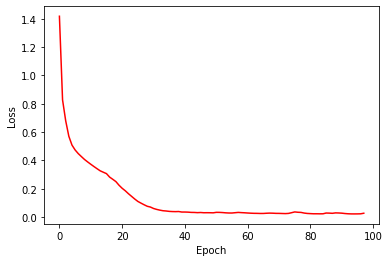

Epoch 99 Batch 0 Loss 0.0214
Epoch 99 Loss 0.0263
Time taken for 1 epoch 21.58385396003723 sec



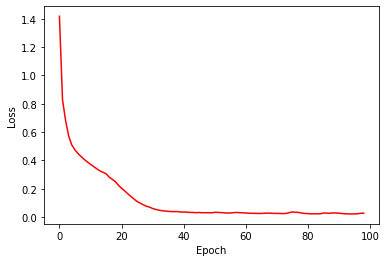

Epoch 100 Batch 0 Loss 0.0227
Epoch 100 Loss 0.0251
Time taken for 1 epoch 24.685889720916748 sec



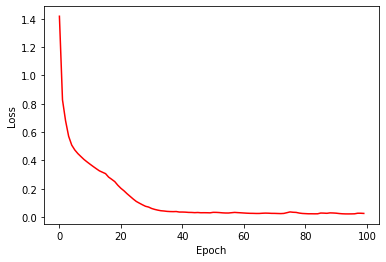

Validation
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.6401515151515151
Mean Reciprocal Rank=0.780193803110469
Testing
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.4989795918367347
Mean Reciprocal Rank=0.6713625688370587
Execution time=6677.665898799896 secs.


In [160]:
#########################################
# MAIN PROGRAM
"""
Lines have been commented out above so that the notebook can be read on git. 
If the attention plots are needed just uncomment the appropriate lines.
All hyperparams have been kept the same though all models.
"""
# Params set from baseline
start_exec_time = time.time()
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
#Vocab setting
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#Read in data
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#batch the data
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#Create encoder with hidden state
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
#Bidirectional so need forward and back
sample_output, forward_h, forward_c, backward_h, backward_c = encoder(example_input_batch, sample_hidden)

#Concat the forward and backward pass as the sample hidden to decoder
sample_hidden = tf.concat([forward_h, backward_h], axis=1)
#Create decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#Get output from decoder, pass in initial state of encoder
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output, initial_state = [forward_h, forward_c, backward_h, backward_c])

#Save checkpoints
checkpoint_dir = root_path + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

#Same epochs for all
epoch = 100
for filename in os.listdir(checkpoint_dir):
  print("Erasing file " +str(filename))
  os.remove(checkpoint_dir + "/" + filename)
print("Training")
train_model(epoch)
print("Validation")
evaluate_model(root_path + path_to_data_val, checkpoint_dir, eval=True)
print("Testing")
evaluate_model(root_path + path_to_data_test, checkpoint_dir, eval=False)

exec_time = time.time() - start_exec_time
print("Execution time="+str(exec_time)+" secs.")